
## Clustering Method: Gaussian Mixture Model

#### Ruoyu Wang
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)


### Executive Summary

We have learned multiple clustering methods thus far. Here we introduce a new method that is distribution-based. Gaussian Mixture Models (GMM) assume each cluser is a probability distribution with a mean of the cluster center and a variance of the cluster shape. In this workflow, We perform GMM on different datasets and attempt to find out their performances and the effects from the hyperparameters (covariance types and the number of clusters). Generally speaking, GMM is a good choice to try when we have elliptical, convex clusters; but the hyperparameters should be chosen carefully as they can largely affect the clustering results.

### Import Packages

In [1]:
import pandas as pd                                                 # reading tabular data
import matplotlib.pyplot as plt                                     # plotting
import matplotlib.gridspec as gridspec                              # plotting
import matplotlib.ticker as ticker                                  # plotting
import numpy as np                                                  # processing data

from sklearn.cluster import KMeans               
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist                            # calculating distance of K Means Clustering
from sklearn.metrics import f1_score                                # performance evaluation

from ipywidgets import interact                                     # interactive plotting

plt.rcParams['figure.dpi'] = 100
plt.rcParams["font.size"] = 12

### Load Data

We will perform clustering on the following datasets:
1. "sample_data_Gaussian_mixture_v1.csv"
2. "nonlinear_facies_v2.csv"

They will be referred to as "Dataset 1" and "Dataset 2" in this workflow.


Both datasets have three columns:
* **Porosity (Por)** - fraction of rock void in units of percentage
* **Acoustic Impedence (AI)** - product of sonic velocity and rock density in units of $kg/m^2s*10^3$
* **Facies** - the character of a rock expressed by its formation, composition, and fossil content.

Porosity and AI are the features of the datasets, and facies are the labels/clusters.

**Note that in real-life, we should use Classification/Supervised ML methods, instead of Clustering for labelled datasets; the labels here are for performance evaluation purposes only, so we can find the most optimal hyperparameters.**

In [2]:
df1 = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_Gaussian_mixture_v1.csv', index_col=0)
df2 = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/nonlinear_facies_v2.csv', index_col=0)

A preview of the datasets:

In [3]:
df1.describe().transpose()

count         mean          std          min          25%  \
Por     477.0    14.479310     2.965744     8.938189    11.749169   
AI      477.0  4494.903124  1357.239351  2590.765673  2901.083181   
Facies  477.0     2.932914     2.186597     0.000000     1.000000   

                50%          75%          max  
Por       16.081174    16.924816    19.135287  
AI      4681.938249  5412.224236  6907.353438  
Facies     3.000000     5.000000     6.000000

In [4]:
df2.describe().transpose()

count        mean         std   min         25%         50%  \
Por     1800.0   17.122778    4.778704   0.0   14.663434   17.674606   
AI      1800.0  625.522917  247.547997  10.0  518.076017  683.865824   
Facies  1800.0    1.666667    0.816723   1.0    1.000000    1.000000   

               75%     max  
Por      20.361860    30.0  
AI      783.315226  1200.0  
Facies    2.000000     3.0

Data normalization is crucial in any distance-based model; we will normalize the features to be in the range [0,1] to ensure accurate distance calculations.

In [5]:
df1.iloc[:, :2] = (df1.iloc[:, :2]-df1.iloc[:, :2].min())/(df1.iloc[:, :2].max()-df1.iloc[:, :2].min())
df2.iloc[:, :2] = (df2.iloc[:, :2]-df2.iloc[:, :2].min())/(df2.iloc[:, :2].max()-df2.iloc[:, :2].min())

The actual facies/labels assignments are:

Dataset 1 has 7 unique facies.
Dataset 2 has 3 unique facies.


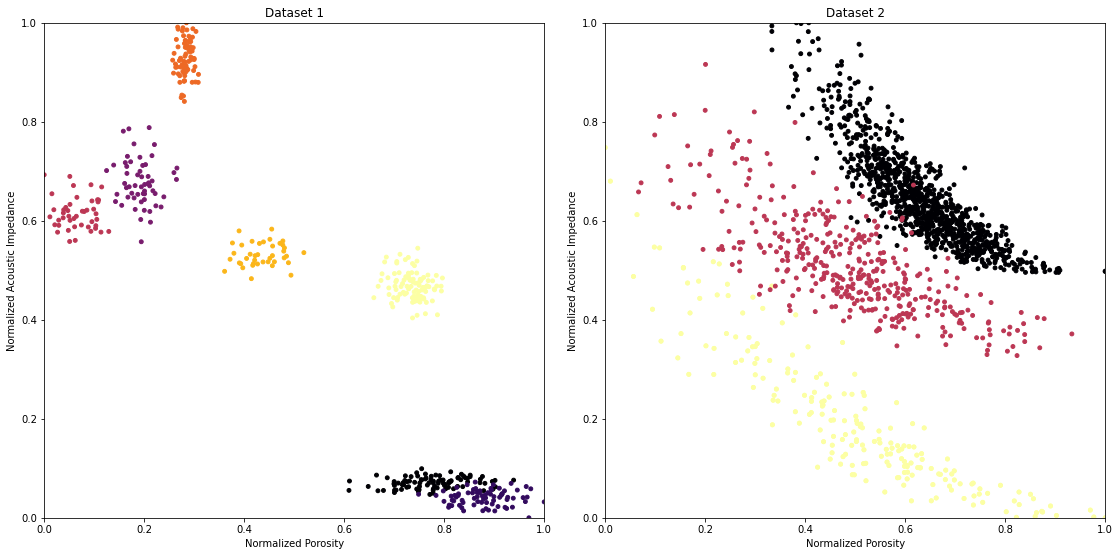

In [6]:
# concatenate the features of the dataset
X1 = df1[['Por', 'AI']].to_numpy()
X2 = df2[['Por', 'AI']].to_numpy()

Y1 = df1['Facies'].to_numpy()
Y2 = df2['Facies'].to_numpy()

print(f"Dataset 1 has {df1['Facies'].nunique()} unique facies.")
print(f"Dataset 2 has {df2['Facies'].nunique()} unique facies.")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
fig.tight_layout(pad=3)
ax1.scatter(X1[:, 0], X1[:, 1], c=Y1, s=15, cmap='inferno')
ax1.set(title='Dataset 1', xlabel='Normalized Porosity', ylabel='Normalized Acoustic Impedance', xlim=(0.0, 1.0), ylim=(0.0, 1.0))
ax2.scatter(X2[:, 0], X2[:, 1], c=Y2, s=15, cmap='inferno')
ax2.set(title='Dataset 2', xlabel='Normalized Porosity', ylabel='Normalized Acoustic Impedance', xlim=(0.0, 1.0), ylim=(0.0, 1.0))
plt.show()

### Clustering Performance Evaluation

Since we have labels available, we will use f1 score, which is a popular classification evaluation technique, to compare the clustering results with reference:

$$F_1=\frac{2}{\text { recall }^{-1}+\text { precision }^{-1}}=2 \frac{\text { precision } \cdot \text { recall }}{\text { precision }+\text { recall }}$$

It is the harmonic mean of precision and recall.


Since the labels generated from clustering methods will have different numbers from our reference, e.g.: for a reference of [0,0,1,1], a generated label of [1,1,0,0] should be perfect but it will have an f1 score of 0.0. Therefore, we write a function to match the labels:

In [7]:
# Performance evaluation
def clustering_metric(true, pred):
    pred_ = pred.copy()
    for i in np.unique(pred):
        index_pred = np.where(pred==i)[0]
        index_true = np.bincount(true[index_pred]).argmax()
        pred_[index_pred] = index_true
    f1 = f1_score(true, pred_, average='macro')
    return round(f1, 4)

### K Means Clustering

K Means Clustering uses prototype method, that is, we specify the number of clusters (*n_clusters*), and *n* random points will be assigned in our feature space as cluster centers. For each centroid, the datapoints with the nearest Euclidean distance will be assigned to its group. In a case where there is overlap and one point could be potentially assigned to multiple groups, K Means Clustering will automatically assign it to the closest centroid. This makes K Means Clustering a less optimal technique when working with non-spherical data.

In [8]:
def k_means_clustering(n_clusters, data):           
    kmeans = KMeans(n_clusters)
    kmeans.fit(data)
    labels = kmeans.predict(data)
    centers = kmeans.cluster_centers_
    return labels, centers

We perform K means clustering and observe the results:

In [9]:
# here n_clusters are chosen to be 7 and 3
labels1, centers1 = k_means_clustering(n_clusters=7, data=X1)
labels2, centers2 = k_means_clustering(n_clusters=3, data=X2)

print(f"F1 score of dataset 1: {clustering_metric(Y1, labels1)}")
print(f"F1 score of dataset 2: {clustering_metric(Y2, labels2)}")

F1 score of dataset 1: 0.948
F1 score of dataset 2: 0.7666


Below are two plots visualizing the K means clustering results. Another way to put the K means clustering algorithm is that it places a circle (if the dataset has two dimensions) or a hypersphere (if datasets have higher dimensions) at the center of each cluster, with a radius of the distance between the center and the furthest point within the cluster. We can see that K means clustering did not work too well for dataset 2, as the facies here have crescent shapes, instead of circular.

The following code snippet is taken from the *Python Data Science Handbook* by **Jake VanderPlas**.

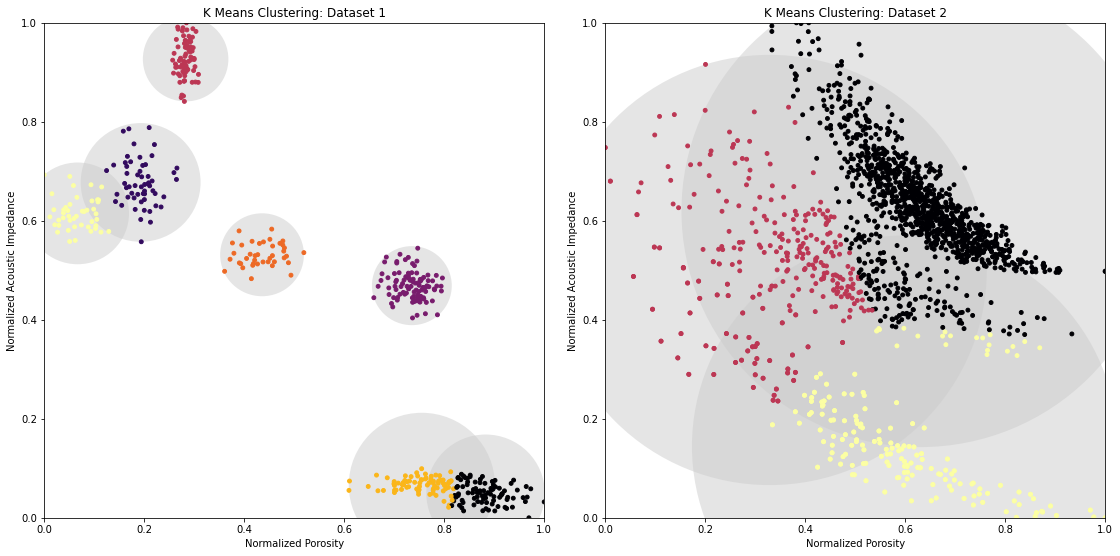

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
fig.tight_layout(pad=3)

ax1.scatter(X1[:, 0], X1[:, 1], c=labels1, s=15, cmap='inferno', zorder=2)
radii = [cdist(X1[labels1 == i], [center]).max() for i, center in enumerate(centers1)]
for c, r in zip(centers1, radii):
    ax1.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
ax1.set(title='K Means Clustering: Dataset 1', xlabel='Normalized Porosity', ylabel='Normalized Acoustic Impedance', xlim=(0.0, 1.0), ylim=(0.0, 1.0))

ax2.scatter(X2[:, 0], X2[:, 1], c=labels2, s=15, cmap='inferno', zorder=2)
radii = [cdist(X2[labels2 == i], [center]).max() for i, center in enumerate(centers2)]
for c, r in zip(centers2, radii):
    ax2.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
ax2.set(title='K Means Clustering: Dataset 2', xlabel='Normalized Porosity', ylabel='Normalized Acoustic Impedance', xlim=(0.0, 1.0), ylim=(0.0, 1.0))

plt.show()

K means clustering, although simple to perform, has some disadvantages: it lacks the flexibility in cluster shapes and probabilistic cluster assignment. We try to address these issues by introducing another clustering method: the Gaussian Mixture Model.

### Gaussian Mixture Model (GMM)

As the name suggests, GMM assumes the data are generated from a mixture of Gaussian distributions; each cluster is a Gaussian distribution and the mean is the cluster center, and the variance controls the cluster shape. 

It uses the prototype method to initialize; at each step, it calculates the weights/probability of each point associated with the center, then update the location and shape of the clusters.

The mathematical form of multivariate d-dimensional Gaussian distribution can be written as:
$$N(x|\mu, \Sigma)=\frac{1}{(2\pi)^{d/2}\sqrt{\Sigma}}exp(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu))$$

where $\mu$ is the mean vector and $\Sigma$ is the covariance matrix of size $d\times d$


In [11]:
def gaussian_mixture_model(n_clusters, data, cov_type):
    gmm = GaussianMixture(n_clusters, covariance_type=cov_type, random_state=0)
    gmm.fit(data)
    labels = gmm.predict(data)
    return labels, gmm

#### Covariance Type Study

There are four types of covariance matrices:

* **Spherical**: diagonal matrix with equal values along the diagonal, so variance is the same along all axes and zero across axes. It sets the shape of the clusters to be equal, and the contours will be oriented in both directions. The resulting clusters will be more similar to k means clustering than others, except that GMM caluclates probabiltiy distribution, while k means measures the distance.

* **Diagonal**: diagonal matrix with different values along the diagonal, which will restrain the contours to align with the coordinate axes.

* **Tied**: the same covariance will be shared by all the gaussians, that is, all gaussians will have the same shape but the shape can be anything.

* **Full**: correlation betweeen random variables is allowed, the cluster can therefore be modeled as any shape in any direction.

The first three matrix types pose constraints on the model and can to some degree reduce the computational time. We will visualize each of these covariance matrices on our datasets:

F1 score of dataset 1 with spherical covariance: 0.9452
F1 score of dataset 1 with diag covariance: 0.9773
F1 score of dataset 1 with tied covariance: 0.9441
F1 score of dataset 1 with full covariance: 0.9775
F1 score of dataset 2 with spherical covariance: 0.736
F1 score of dataset 2 with diag covariance: 0.6661
F1 score of dataset 2 with tied covariance: 0.9667
F1 score of dataset 2 with full covariance: 0.9374


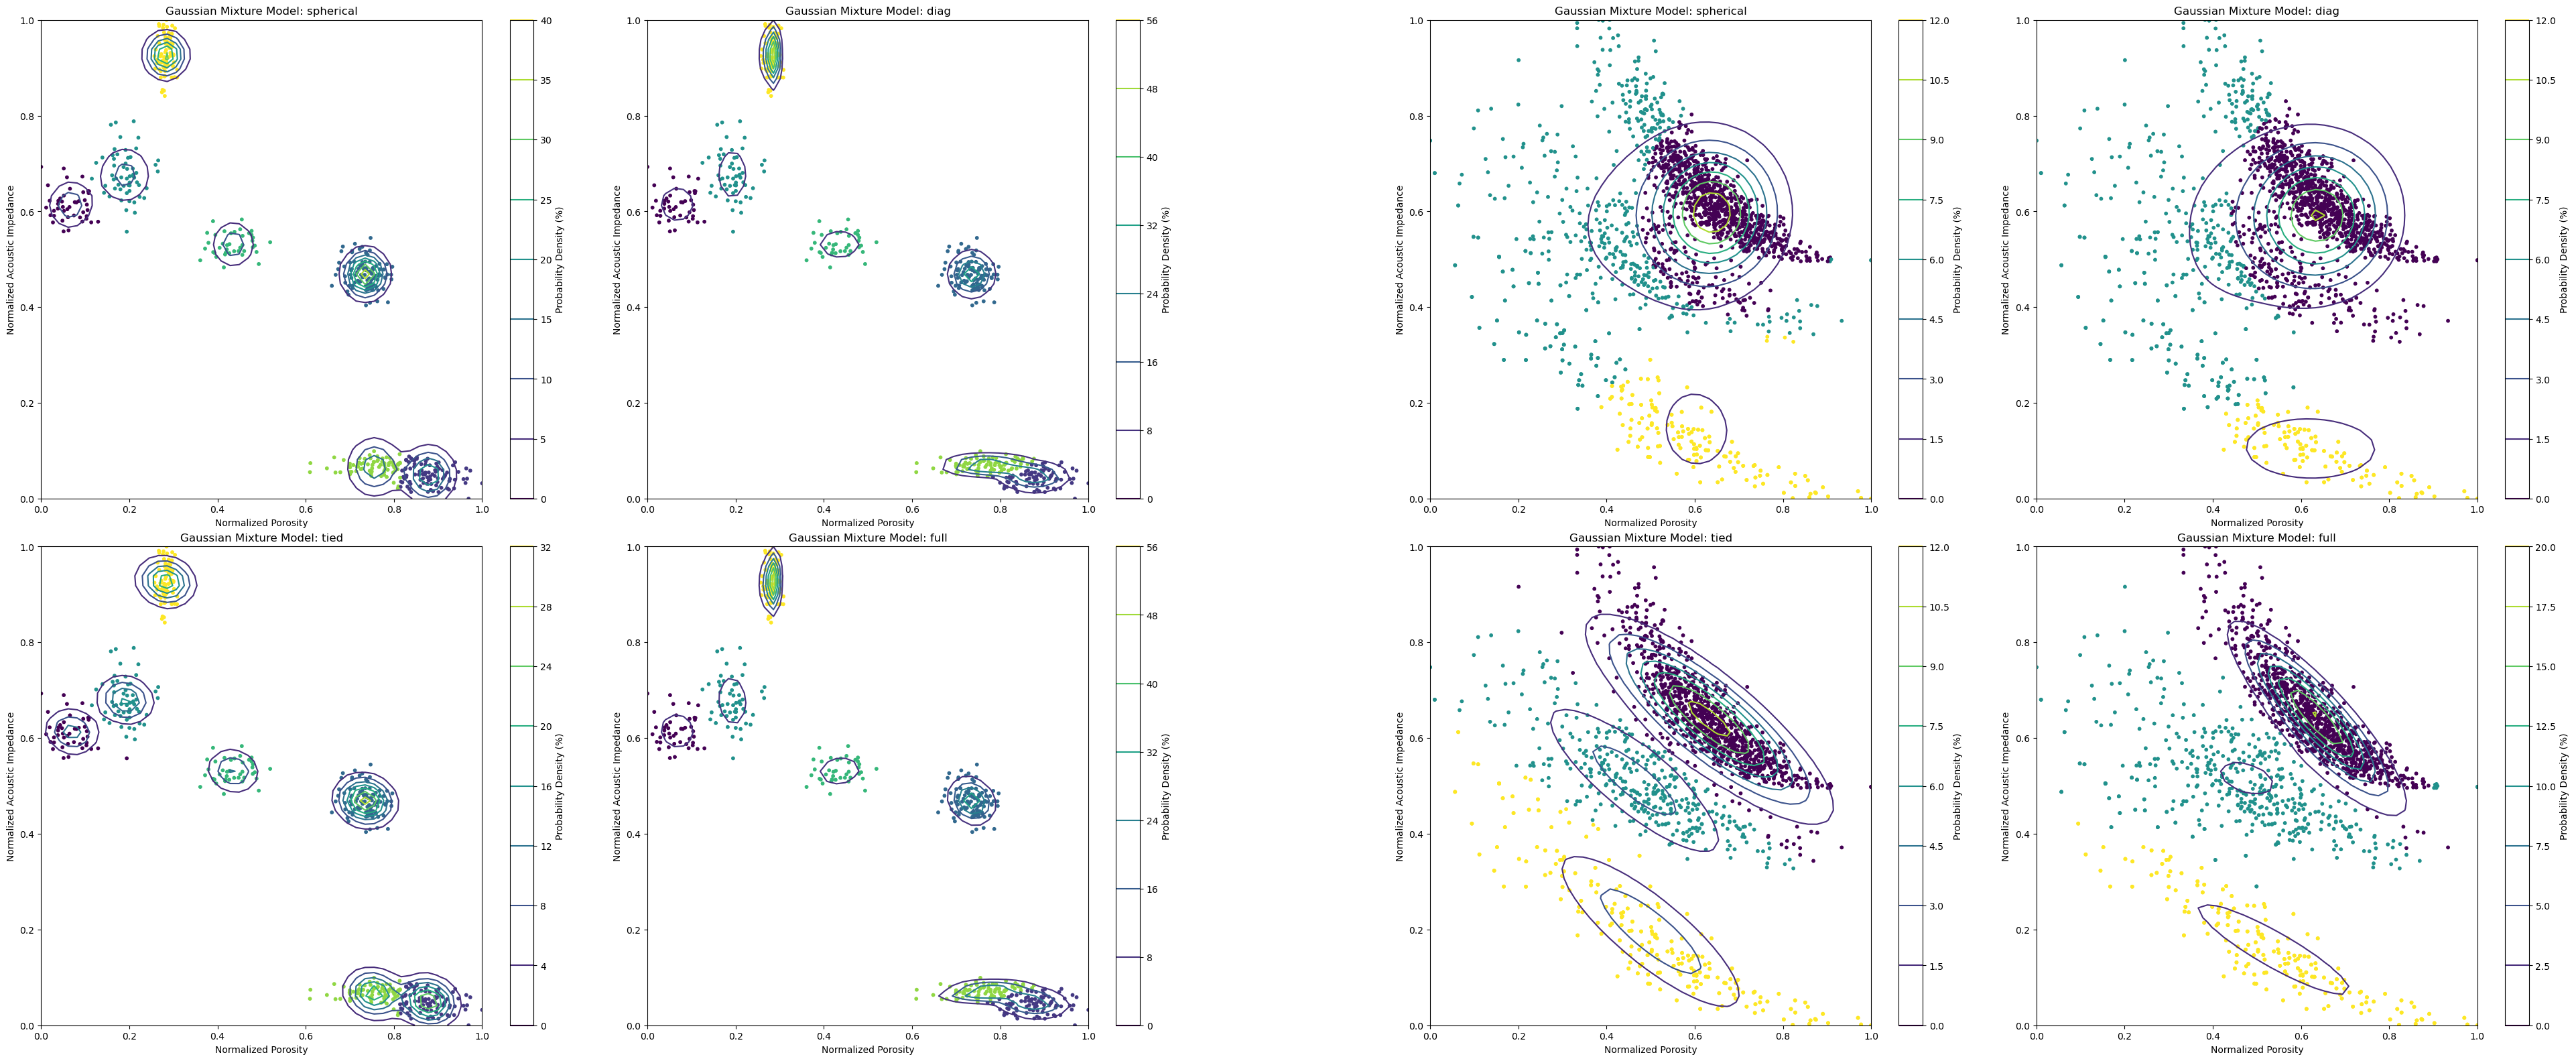

In [12]:
cov_type =  ["spherical", "diag", "tied", "full"]
n_clusters = [7, 3]
data = [X1, X2]
label_true = [Y1, Y2]              

# create a grid that covers our feature space to plot the contours of the clusters
grid = np.linspace(0, 1)
X, Y = np.meshgrid(grid, grid)

fig = plt.figure(figsize=(16, 8), dpi=100)
fig.tight_layout(pad=2)
outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)
for i in range(len(data)):
    inner = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer[i], wspace=0.1, hspace=0.1)

    for j in range(len(cov_type)):
        ax = plt.Subplot(fig, inner[j])
        cov = cov_type[j]
        labels, gmm = gaussian_mixture_model(n_clusters[i], data[i], cov)
        print(f"F1 score of dataset {i+1} with {cov} covariance: {clustering_metric(label_true[i], labels)}")
        Z = np.exp(gmm.score_samples(np.array([X.ravel(), Y.ravel()]).T).reshape(X.shape))
        ax.scatter(data[i][:, 0], data[i][:, 1], c=labels, s=10, zorder=2)
        cf = ax.contour(X, Y, Z)
        ax.set(title=f'Gaussian Mixture Model: {cov}', xlabel='Normalized Porosity', ylabel='Normalized Acoustic Impedance')
        fig.add_subplot(ax)
        fig.colorbar(cf, ax=ax, label='Probability Density (%)')
        fig.subplots_adjust(right=2.5, top=2.0)

The plots above and the f1 scores showed that "full" and "tied" are the most optimal covariance types for dataset 1 and 2. The contour plots the probability density (in the unit of percentage) within our feature space. The clusters with denser points have higher probability densities. We check if the probability density calculation is true by integrating it over the feature space:

In [13]:
(grid[1] - grid[0])**2 * Z.sum()

0.9903009434890645

We can normalize the contours by each cluster to more closely examine the contour shapes:

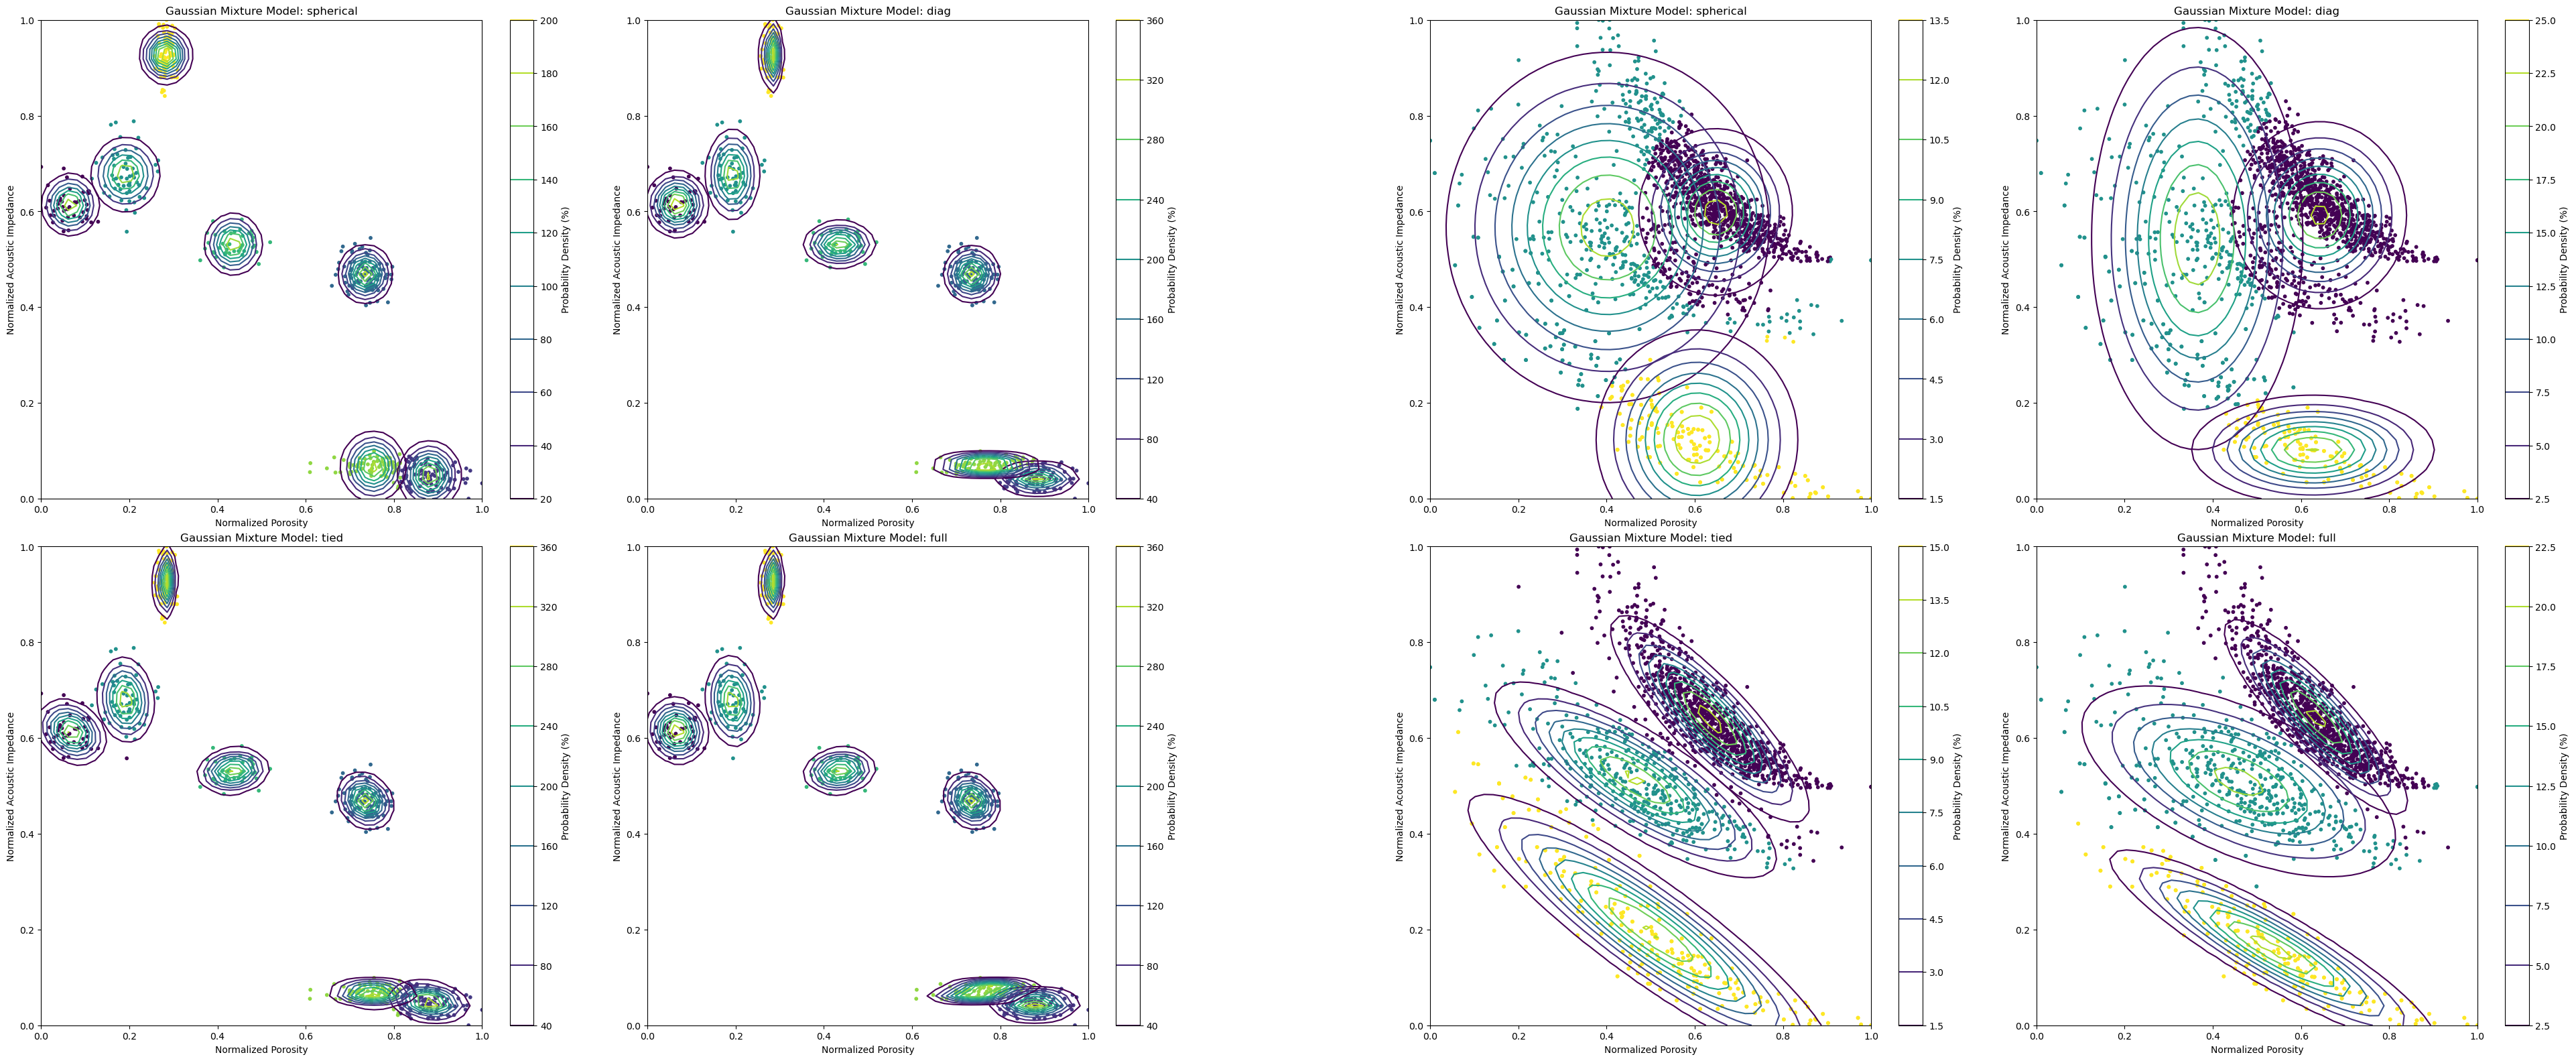

In [14]:
fig = plt.figure(figsize=(16, 8), dpi=100)
fig.tight_layout(pad=2)
outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)
for i in range(len(data)):
    inner = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer[i], wspace=0.1, hspace=0.1)

    for j in range(len(cov_type)):
        ax = plt.Subplot(fig, inner[j])
        cov = cov_type[j]
        labels, gmm = gaussian_mixture_model(n_clusters[i], data[i], cov)
        ax.scatter(data[i][:, 0], data[i][:, 1], c=labels, s=10, zorder=2)
        for k in np.unique(labels):
            data_ = data[i][labels==k]
            gmm_ = gaussian_mixture_model(1, data_, cov)[1]
            Z = np.exp(gmm_.score_samples(np.array([X.ravel(), Y.ravel()]).T).reshape(X.shape))
            cf = ax.contour(X, Y, Z, locator = ticker.MaxNLocator(prune = 'lower'))
        ax.set(title=f'Gaussian Mixture Model: {cov}', xlabel='Normalized Porosity', ylabel='Normalized Acoustic Impedance')
        fig.add_subplot(ax)
        fig.colorbar(cf, ax=ax, label='Probability Density (%)')
        fig.subplots_adjust(right=2.5, top=2.0)

#### *n_clusters* Study

We need to specify the number of clusters to perform Gaussian Mixture clustering. There are two common metrics:
* **Akaike information criterion**: 
$$AIC=2p-2\ln{L}$$

* **Bayesian information criterion**:
$$BIC=-2\ln{L}+p\ln{N}$$

where $p$ is the number of model parameters, $L$ is the posterior, and $N$ is the total number of data points.

The number of parameters for a model with $m$ features and $N$ clusters is given as:

$$p=m\times m\times N+m\times N+N$$

which corresponds to $N$ covariance matrices of size $m\times m$, $N$ mean vectors of length $m$, and a weight vector of length $N$.

Compare to AIC, BIC penalizes model complexity more. For both metrics, the lower the scores are, the better the model.

We calculate the AIC and BIC for both datasets, given covariance types "full" and "tied".

In [15]:
n_clusters = np.arange(1,10)
cov = ['full', 'tied']
aics = []
bics = []
for i in range(len(data)):
    gmms = [gaussian_mixture_model(n_cluster, data[i], cov[i])[1] for n_cluster in n_clusters]
    aics.append([gmm.aic(data[i]) for gmm in gmms])
    bics.append([gmm.bic(data[i]) for gmm in gmms])

We visualize the results:

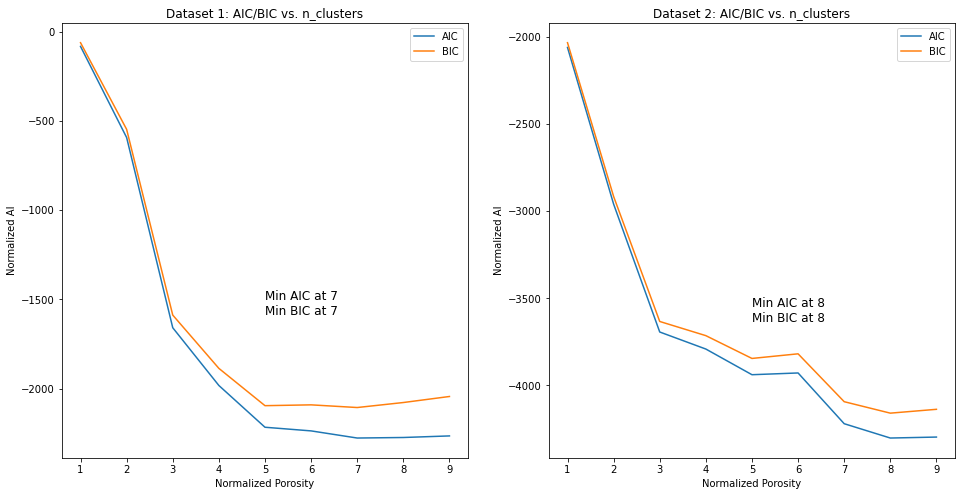

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.plot(n_clusters, aics[0], label='AIC'); ax1.plot(n_clusters, bics[0], label='BIC')
ax2.plot(n_clusters, aics[1], label='AIC'); ax2.plot(n_clusters, bics[1], label='BIC')
ax1.text(5, bics[0][2], s=f'Min AIC at {np.argmin(aics[0])+1}\nMin BIC at {np.argmin(bics[0])+1}', size=12)
ax2.text(5, bics[1][2], s=f'Min AIC at {np.argmin(aics[1])+1}\nMin BIC at {np.argmin(bics[1])+1}', size=12)
ax1.set(title='Dataset 1: AIC/BIC vs. n_clusters', xlabel='Normalized Porosity', ylabel='Normalized AI')
ax2.set(title='Dataset 2: AIC/BIC vs. n_clusters', xlabel='Normalized Porosity', ylabel='Normalized AI')
ax1.legend(); ax2.legend()
plt.show()

The BIC and AIC scores showed that the lowest scores do not always correspond to the "correct" number of components; as the number of clusters increase, both model parameters and log likelihood increase, but BIC or AIC could increase or decrease. They are a good rule of thumb but are not always guaranteed to give the best result. For example, for dataset 2, at $n=3$ there was a sharp gradient change/elbow, we can say 3 is the best choice for *n_clusters* too since the results are good enough and it is less computationally expensive than having 8 clusters. 

### Interactive Plots for GMM

Below is an interactive plot for GMM, one can change the hyperparameters and input dataset at will and visualize the results.

In [17]:
@interact(n_clusters=(1,10,1), dataset=['1', '2'], cov_type=['spherical','diag','tied','full'])
def interactive_gmm(n_clusters, dataset, cov_type):
    data = eval(f'X{dataset}')
    labels, gmm = gaussian_mixture_model(n_clusters, data, cov_type)
    X, Y = np.meshgrid(np.linspace(0,1), np.linspace(0,1))
    Z = np.exp(gmm.score_samples(np.array([X.ravel(), Y.ravel()]).T).reshape(X.shape))
    plt.scatter(data[:, 0], data[:, 1], c=labels, s=10)
    plt.contour(X, Y, Z, cmap='jet')
    plt.title('Gaussian Mixture Model Interactive Plot')
    plt.xlabel('Normalized porosity')
    plt.ylabel('Normalized AI')

interactive(children=(IntSlider(value=5, description='n_clusters', max=10, min=1), Dropdown(description='datas…

### Results

We learned that Gaussian Mixture Models overcome some of the disadvantages K Means clustering has. A good rule of thumb when choosing hyperparameters is:
1. Covariance type: closely examine the cluster shapes by eye; if there are overlapped clusters, try to visualize how we want to "divide" the clusters. "Full" is generally a good way to go as the cluster shapes can be either spherical or elliptical stretching in any direction.
2. Number of components: perform a BIC/AIC analysis when *n* is hard to tell by eye.


With a 'full' and 'tied' covariance matrix, and 7 and 3 clusters, dataset 1 and dataset 2 have the following clustering results:

F1 score of dataset 1: 0.9775
F1 score of dataset 2: 0.9667


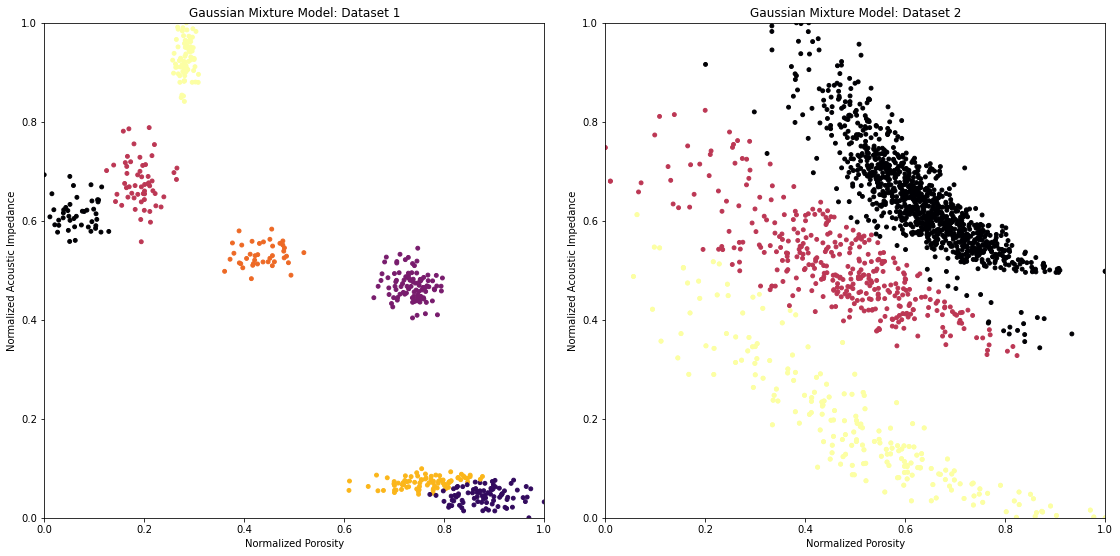

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
fig.tight_layout(pad=3)

labels1 = gaussian_mixture_model(7, X1, 'full')[0]
ax1.scatter(X1[:, 0], X1[:, 1], c=labels1, s=15, cmap='inferno', zorder=2)
ax1.set(title='Gaussian Mixture Model: Dataset 1', xlabel='Normalized Porosity', ylabel='Normalized Acoustic Impedance', xlim=(0.0, 1.0), ylim=(0.0, 1.0))
print(f"F1 score of dataset 1: {clustering_metric(Y1, labels1)}")

labels2 = gaussian_mixture_model(3, X2, 'tied')[0]
ax2.scatter(X2[:, 0], X2[:, 1], c=labels2, s=15, cmap='inferno', zorder=2)
ax2.set(title='Gaussian Mixture Model: Dataset 2', xlabel='Normalized Porosity', ylabel='Normalized Acoustic Impedance', xlim=(0.0, 1.0), ylim=(0.0, 1.0))
print(f"F1 score of dataset 2: {clustering_metric(Y2, labels2)}")

plt.show()

### About Me

Hi! I am currently a MS student in the Hildebrand Department of Petroleum and Geosystems Engineering. I am part of the Digital Reservoir Characterization Technology (DIRECT) Lab, and am being supervised by Profs. John T. Foster, Larry Lake, and Michael Pyrcz. My research is focused on developing novel Machine Learning methods on production prediction and reservoir engineering.

I hope this workflow on Gaussian Mixture Models was helpful,

*Ruoyu Wang*

rwang125@utexas.edu | [GitHub](https://github.com/RuoyuWang72) | [LinkedIn](https://www.linkedin.com/in/ruoyu-wang125/)

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
